# Record Linkage Comparison Analysis

### Project Description

This is a project that seeks to:
* classify anonymous patient records from the [UCI Record Linkage Repository](https://archive.ics.uci.edu/ml/datasets/Record+Linkage+Comparison+Patterns)
* decide whether some of the column information is more relevant than others in correctly classifying the records

The code below implements classification using a neural network (NN). In order to investigate the relevance or otherwise of various columns, data from various combinations of columns will be fed into the NN. An analysis of the results will help to shed light on which columns of the data, if any, can be rendered redundant in the classification task.

### Project Value

If it turns out that some columns in the data are indeed not that relevant in correctly classifying the records, this project has the potential to reduce the amount of information required to be collected from patients in order to identify them. It would also help with record linking for patient data that is currently unclassified. This is very useful for for avoiding accidents that arise from treating patients based on inaccurate medical information, while also protecting privacy by potentially reducing the amount of information that must be obtained from patients. 

More generally, the potential implications are also relevant for many other sectors of society where restriction of information is of importance, such as in commerce, communications and national security.

### A note on the data

The data set is split into 10 blocks of (approximately) equal size and ratio of matches to non-matches.

The data contains 5,749,132 records, of which 20,931 are matches. This means that it is heavily skewed, with less than half of a percent representing positive cases (i.e., a match). Some strategies employed to mitigate this skew are:
* Including only a subset of the negative cases in training the algorithm. In the code below, a positive:negative ratio of 4:1 is used.
* Increasing the weights of the positive examples over the negative examples in the data during training.
* Assessing the algorithm's performance using a precision-recall approach ([F1 score](https://en.wikipedia.org/wiki/F1_score)), rather than prediction accuracy.

### Data column description:

1. id_1: internal identifier of first record. 
2. id_2: internal identifier of second record. 
3. cmp_fname_c1: agreement of first name, first component 
4. cmp_fname_c2: agreement of first name, second component 
5. cmp_lname_c1: agreement of family name, first component 
6. cmp_lname_c2: agreement of family name, second component 
7. cmp_sex: agreement sex 
8. cmp_bd: agreement of date of birth, day component 
9. cmp_bm: agreement of date of birth, month component 
10. cmp_by: agreement of date of birth, year component 
11. cmp_plz: agreement of postal code 
12. is_match: matching status (TRUE for matches, FALSE for non-matches) 

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.utils import shuffle
import math as math
import matplotlib.pyplot as plt

In [2]:
# read in data
block_1 = pd.read_csv('Records/block_1.csv')
block_2 = pd.read_csv('Records/block_2.csv')
block_3 = pd.read_csv('Records/block_3.csv')
block_4 = pd.read_csv('Records/block_4.csv')
block_5 = pd.read_csv('Records/block_5.csv')
block_6 = pd.read_csv('Records/block_6.csv')
block_7 = pd.read_csv('Records/block_7.csv')
block_8 = pd.read_csv('Records/block_8.csv')
block_9 = pd.read_csv('Records/block_9.csv')
block_10 = pd.read_csv('Records/block_10.csv')

In [3]:
# merge data
block = pd.concat([block_1, block_2, block_3, block_4, block_5, block_6, block_7, block_8, block_9, block_10])

'block' can be saved to avoid having to reload all 10 blocks in the future:

In [4]:
# save 'block'
pickled = open("pickled_data/block.pickle","wb")
pickle.dump(block, pickled)
pickled.close()

The code block below reads in 'block' whenever needed:

In [3]:
# read in 'block'
read_pickled = open("pickled_data/block.pickle","rb")
block = pickle.load(read_pickled)
read_pickled.close()

In [31]:
# display a subset of the data

block.head()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333333333333,?,1.0,?,1,1,1,1,0,True
1,39086,47614,1,?,1.0,?,1,1,1,1,1,True
2,70031,70237,1,?,1.0,?,1,1,1,1,1,True
3,84795,97439,1,?,1.0,?,1,1,1,1,1,True
4,36950,42116,1,?,1.0,1,1,1,1,1,1,True


The columns '*cmp_fname_c2*' and '*cmp_lname_c2*' are made up almost entirely of '*?*' (unknown), so they will be excluded from the data

In [13]:
# % of '?' in cmp_fname_c2
block['cmp_fname_c2'].value_counts()['?']/block['cmp_fname_c2'].count() * 100

98.196284239081649

In [14]:
# % of '?' in cmp_lname_c2
block['cmp_lname_c2'].value_counts()['?']/block['cmp_lname_c2'].count() * 100

99.957141356295182

In [35]:
# select columns (drop cmp_fname_c2 and cmp_lname_c2 - they contain almost all '?' (unknown))
block = block.loc[:,['cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_bd','cmp_bm','cmp_by','cmp_plz','is_match']]

In [36]:
# drop rows containing '?' (unknown)
block = block[(block['cmp_plz'] != '?')]

In [37]:
block = block[(block['cmp_by'] != '?')]

In [38]:
block = block[(block['cmp_fname_c1'] != '?')]

In [39]:
# separate data into match and non-match sets for separate analysis
match = block[(block['is_match'] == True)]

In [12]:
non_match = block[(block['is_match'] == False)]

Once again, 'match' and 'non_match' can be saved to avoid having to go through all the above data wrangling in the future:

In [13]:
# save 'match' and 'non_match'

pickled = open("pickled_data/match.pickle","wb")
pickle.dump(non_match, pickled)
pickled.close()

pickled = open("pickled_data/match.pickle","wb")
pickle.dump(non_match, pickled)
pickled.close()

The block below reads in 'match' and 'non_match' whenever needed:

In [4]:
# read in 'match' and 'non_match'

read_pickled = open("pickled_data/match.pickle","rb")
match = pickle.load(read_pickled)
read_pickled.close()

read_pickled = open("pickled_data/non_match.pickle","rb")
non_match = pickle.load(read_pickled)
read_pickled.close()

Display subsets of 'match' and 'non_match':

In [40]:
match.head()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,0.833333333333333,1.0,1,1,1,1,0,True
1,1,1.0,1,1,1,1,1,True
2,1,1.0,1,1,1,1,1,True
3,1,1.0,1,1,1,1,1,True
4,1,1.0,1,1,1,1,1,True


In [5]:
non_match.head()

,cmp_fname_c1,cmp_lname_c1,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
2093,1,0.166667,1,0,0,1,0,False
2094,1,0.200000,1,0,0,1,0,False
2095,0,0.500000,1,0,0,0,0,False
2096,1,0.333333,1,1,0,0,0,False
2097,1,0.111111,1,0,0,1,0,False


Plotting a correlation heatmap helps to give some rudimentary information about the relationships of the various columns to each other


In [112]:
# exclude last column (match label)
match_sub = match.iloc[:, :-1]
non_match_sub = non_match.iloc[:, :-1]

In [117]:
# cast to numeric ('coerce' repaces errors with NaN)
match_sub = match_sub.apply(pd.to_numeric, errors = 'coerce')
non_match_sub = non_match_sub.apply(pd.to_numeric, errors = 'coerce')

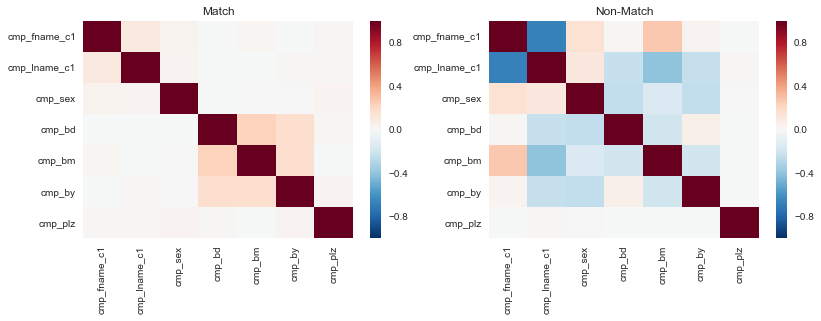

In [118]:
# plot correlation heatmaps
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = plt.figaspect(0.3))
sns.heatmap((match_sub.corr()), ax = ax[0])
sns.heatmap((non_match_sub.corr()), ax = ax[1])
ax[0].set_title('Match')
ax[1].set_title('Non-Match')

A cursory glance at the heatmap points to the birthdate information ('cmp_bd', 'cmp_bm' and 'cmp_by') as a possibly related group of columns. We will investigate this group later with the neural network.

Data from 'match' and 'non_match' can now be combined to create training, validation and testing sets for the neural network.

* Both sets ('match' and 'non_match') will be shuffled just to get rid of any possible ordering that may exist in the data
* Both sets will be divided into training, validation and testing slices in the ratio 3:1:1

In [6]:
# shuffle the data
match = shuffle(match)
non_match = shuffle(non_match)

In [7]:
# split into training, validation and testing sets in the ration 3:1:1

fifth = len(match)//5
match_train = match.iloc[0:3*fifth, :]
match_val = match.iloc[1 + 3*fifth:4*fifth, :]
match_test = match.iloc[1 + 4*fifth:, :]

In [8]:
fifth = len(non_match)//5
non_match_train = non_match.iloc[0:3*fifth, :]
non_match_val = non_match.iloc[1 + 3*fifth:4*fifth, :]
non_match_test = non_match.iloc[1 + 4*fifth:, :]

The data is heavily skewed - only 0.36% of the entire data constitutes the match set.
* To reduce the effect of this skew, we will combine the training and validation match sets with only a subset of the non_match sets to give a match:non_match ratio of 1:4
* All the data in the test set will be retained to simulate real-world data for testing
* The combined 'match'+'non_match' data sets will be shuffled again

In [9]:
# merge match set with slice of non_match set that is 4 times the length of match set
train_set = pd.concat([match_train, non_match_train.iloc[0:4*len(match_train),:]])
val_set = pd.concat([match_val, non_match_val.iloc[0:4*len(match_val),:]])

# leave test set whole (real-world data)
test_set = pd.concat([match_test, non_match_test])

In [11]:
# shuffle again
train_set = shuffle(train_set)
val_set = shuffle(val_set)
test_set = shuffle(test_set)

# df = df.sample(frac=1).reset_index(drop=True)

We will train the neural network with 3 variations of columns in 'train_set'. Based on the preliminary observation from the correlation heatmap:
* 'all_columns' will contain all the 7 features of interest: 'cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_bd','cmp_bm','cmp_by' and 'cmp_plz'
* 'set_1' will contain the 3 features representing birth date information: 'cmp_bd', 'cmp_bm' and 'cmp_by'
* 'set_2' will contain the other 4 features: 'cmp_fname_c1','cmp_lname_c1','cmp_by' and 'cmp_plz'

Since our neural network will be implementing binary classification, it will be beneficial to represent our labels as [1 0] (representing a '1' or a match) and [0 1] (representing a '0' or no match). A helper function '**shape_labels**' will help to shape the label columns into the appropriate two-column represtations.

In [13]:
def shape_labels(labels, dim):
    
    shaped_labels = np.zeros((len(labels), dim))
    shaped_labels[:,0] = labels
    shaped_labels[:,1] = 1 - labels
    
    return shaped_labels

In [81]:
# Create input and label sets for all_columns

train_input = np.array(train_set.iloc[:, :-1]).astype(np.float32)
temp_labels = np.array((train_set.iloc[:, -1]).astype(np.float32))
train_labels = shape_labels(temp_labels, 2).astype(np.float32)

val_input = np.array(val_set.iloc[:, :-1]).astype(np.float32)
temp_labels = np.array((val_set.iloc[:, -1]).astype(np.float32))
val_labels = shape_labels(temp_labels, 2).astype(np.float32)

test_input = np.array(test_set.iloc[:, :-1]).astype(np.float32)
temp_labels = np.array((test_set.iloc[:, -1]).astype(np.float32))
test_labels = shape_labels(temp_labels, 2).astype(np.float32)

In [ ]:
# Create input and label sets for set_1 ('cmp_bd', 'cmp_bm' and 'cmp_by')

# train_input = np.array(train_set.loc[:,['cmp_bd','cmp_bm','cmp_by']]).astype(np.float32)
# temp_labels = np.array((train_set.iloc[:, -1]).astype(np.float32))
# train_labels = shape_labels(temp_labels, 2).astype(np.float32)

# val_input = np.array(val_set.loc[:,['cmp_bd','cmp_bm','cmp_by']]).astype(np.float32)
# temp_labels = np.array((val_set.iloc[:, -1]).astype(np.float32))
# val_labels = shape_labels(temp_labels, 2).astype(np.float32)

# test_input = np.array(test_set.loc[:,['cmp_bd','cmp_bm','cmp_by']]).astype(np.float32)
# temp_labels = np.array((test_set.iloc[:, -1]).astype(np.float32))
# test_labels = shape_labels(temp_labels, 2).astype(np.float32)

In [106]:
# Create input and label sets for set_2 ('cmp_fname_c1','cmp_lname_c1','cmp_by' and 'cmp_plz')

# train_input = np.array(train_set.loc[:,['cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_plz']]).astype(np.float32)
# temp_labels = np.array((train_set.iloc[:, -1]).astype(np.float32))
# train_labels = shape_labels(temp_labels, 2).astype(np.float32)

# val_input = np.array(val_set.loc[:,['cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_plz']]).astype(np.float32)
# temp_labels = np.array((val_set.iloc[:, -1]).astype(np.float32))
# val_labels = shape_labels(temp_labels, 2).astype(np.float32)

# test_input = np.array(test_set.loc[:,['cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_plz']]).astype(np.float32)
# temp_labels = np.array((test_set.iloc[:, -1]).astype(np.float32))
# test_labels = shape_labels(temp_labels, 2).astype(np.float32)

We are now ready to model the neural network.

The model employed is as follows:
* 3 hidden layers (1024 nodes each)
 - RELU (Rectified Linear Unit) activation functions
* Overfitting controls
 - Regularization using a learning rate with exponential decay
 - Dropout implemented on the first hidden layer
* Data skew control
 - Biased weighting of the under-represented positive examples
* Performance assessment
 - Precision-recall (F1 score)

In [107]:
'''
Model:

--> NN with 3 hidden layers
    > RELUs
    
--> Overfitting measures
    > L2 Regularization
        -> Learning rate (beta) with exponential decay
    > Dropout
    
--> Skew control
    > Biased weighting of the under-represented positive examples
    
--> Assessment via precision-recall (F1 score)

'''

all_columns = ['cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_bd','cmp_bm','cmp_by','cmp_plz']
set_1 = ['cmp_bd','cmp_bm','cmp_by']
set_2 = ['cmp_fname_c1','cmp_lname_c1','cmp_sex','cmp_plz']
features = set_2

batch_size = 128
beta = 0.05
start_learning_rate = 0.5
p_weight = 0.5 # weight in loss function for positive examples

input_nodes = len(features)
hidden_nodes_1 = 1024
hidden_nodes_2 = hidden_nodes_1
hidden_nodes_3 = hidden_nodes_1
num_labels = 2

pos, neg = np.zeros((1, 2)), np.zeros((1, 2))
pos[0][0]  = 1
neg[0][1]  = 1

pred_cutoff = 0.5 # cutoff for predicting 1 or 0

test_sample = 50000 # length of test input to use

graph = tf.Graph()
with graph.as_default():

    '''Input Data'''
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_nodes))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(val_input)
    tf_valid_labels = tf.constant(val_labels)
    tf_test_dataset = tf.constant(test_input[0:test_sample,:])
    tf_test_labels = tf.constant(test_labels[0:test_sample,:])
    #Placeholder for dropout probability
    keep_prob = tf.placeholder("float")

    '''Variables'''
    # Hidden RELU layer 1
    weights_1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes_1], stddev=math.sqrt(2.0/input_nodes)))
    biases_1 = tf.Variable(tf.zeros([hidden_nodes_1]))
    
    # Hidden RELU layer 2
    weights_2 = tf.Variable(tf.truncated_normal([hidden_nodes_1, hidden_nodes_2], stddev=math.sqrt(2.0/hidden_nodes_1)))
    biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))
    
    # Hidden RELU layer 3
    weights_3 = tf.Variable(tf.truncated_normal([hidden_nodes_2, hidden_nodes_3], stddev=math.sqrt(2.0/hidden_nodes_2)))
    biases_3 = tf.Variable(tf.zeros([hidden_nodes_3]))
    
    # Output layer
    output_weights = tf.Variable(tf.truncated_normal([hidden_nodes_3, num_labels], stddev=math.sqrt(2.0/hidden_nodes_3)))
    output_biases = tf.Variable(tf.zeros([num_labels]))
    
    
    '''Training computation'''
    # Hidden RELU layer 1
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    hidden_layer_1 = tf.nn.relu(logits_1)
    # Dropout on hidden layer: RELU layer
    hidden_layer_1_dropout = tf.nn.dropout(hidden_layer_1, keep_prob)
    
    # Hidden RELU layer 2
    logits_2 = tf.matmul(hidden_layer_1_dropout, weights_2) + biases_2
    hidden_layer_2 = tf.nn.relu(logits_2)
    # Dropout on hidden layer: RELU layer
#     hidden_layer_2_dropout = tf.nn.dropout(hidden_layer_2, keep_prob)
    
    # Hidden RELU layer 3
    logits_3 = tf.matmul(hidden_layer_2, weights_3) + biases_3
    hidden_layer_3 = tf.nn.relu(logits_3)
    # Dropout on hidden layer: RELU layer
#     hidden_layer_3_dropout = tf.nn.dropout(hidden_layer_3, keep_prob)
    
    # Output layer
    output_logits = tf.matmul(hidden_layer_3, output_weights) + output_biases
    
    
    
    # Loss function
    loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets = tf_train_labels, logits = output_logits, pos_weight = p_weight))
    # Loss function with L2 Regularization with decaying learning rate beta
    regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + \
                   tf.nn.l2_loss(weights_3) + tf.nn.l2_loss(output_weights)

    loss = tf.reduce_mean(loss + beta * regularizers)
    
    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    
    # Training predictions
    train_prediction = tf.nn.softmax(output_logits)
    
    
    # Validation predictions
    valid_logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    valid_relu_1 = tf.nn.relu(valid_logits_1)
    
    valid_logits_2 = tf.matmul(valid_relu_1, weights_2) + biases_2
    valid_relu_2 = tf.nn.relu(valid_logits_2)
    
    valid_logits_3 = tf.matmul(valid_relu_2, weights_3) + biases_3
    valid_relu_3 = tf.nn.relu(valid_logits_3)
    
    valid_output_logits = tf.matmul(valid_relu_3, output_weights) + output_biases
    
    valid_loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets = tf_valid_labels, logits = valid_output_logits, pos_weight = p_weight))
    valid_loss = tf.reduce_mean(valid_loss + beta * regularizers)
    
    valid_prediction = tf.nn.softmax(valid_output_logits)
    
    
    # Test predictions
    test_logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    test_relu_1 = tf.nn.relu(test_logits_1)
    
    test_logits_2 = tf.matmul(test_relu_1, weights_2) + biases_2
    test_relu_2 = tf.nn.relu(test_logits_2)
    
    test_logits_3 = tf.matmul(test_relu_2, weights_3) + biases_3
    test_relu_3 = tf.nn.relu(test_logits_3)

    test_output_logits = tf.matmul(test_relu_3, output_weights) + output_biases
    
    test_loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets = tf_test_labels, logits = test_output_logits, pos_weight = p_weight))
    test_loss = tf.reduce_mean(test_loss + beta * regularizers)
    
    test_prediction = tf.nn.softmax(test_output_logits)

In [19]:
def F1_score(predictions, labels, pos, neg, pred_cutoff):

    encoded_predictions = predictions > pred_cutoff
    
    tp = np.sum((encoded_predictions == pos)[:,0] & (labels == pos)[:,0])
    fp = np.sum((encoded_predictions == pos)[:,0] & (labels == neg)[:,0])
    fn = np.sum((encoded_predictions == neg)[:,0] & (labels == pos)[:,0])
        
    if tp + fp == 0: # troubleshooting tool: indicates extreme bias toward predicting negative
        return -1
    
    prec = tp/(tp + fp)
    rec = tp/(tp + fn)

    F1 = 2*prec*rec/(prec + rec)
    
    return F1
    
#     return 100*F1

We can now train the neural network and carry out prediction/classification

In [120]:
num_steps = 2000

#lists to hold loss values for plotting
l_train = []
l_val = []
l_test = []

#lists to hold F1 values
train_F1 = []
valid_F1 = []
test_F1 = []

drop = 0.1 #fraction to discard in dropout
sample_interval = 20

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    print("Initialized")
    
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_input[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 1 - drop}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % sample_interval == 0):
#             print("Minibatch loss at step {}: {}".format(step, l))
#             print("Minibatch F1_score: {:.1f}".format(F1_score(predictions, batch_labels, pos, neg, pred_cutoff)))
#             print("Validation F1_score: {:.1f}".format(F1_score(valid_prediction.eval(), val_labels, pos, neg, pred_cutoff)))
#             print("\n")
            
            train_F1.append(F1_score(predictions, batch_labels, pos, neg, pred_cutoff))
            valid_F1.append(F1_score(valid_prediction.eval(), val_labels, pos, neg, pred_cutoff))
            test_F1.append(F1_score(test_prediction.eval(), test_labels[0:test_sample,:], pos, neg, pred_cutoff))
            print(step, end = ' ')
            
            l_train.append(l)
            l_val.append(valid_loss.eval())
            l_test.append(test_loss.eval())
            
    print("\n\nTraining F1: {:.1f}".format(F1_score(predictions, batch_labels, pos, neg, pred_cutoff)))
    print("Validation F1: {:.1f}".format(F1_score(valid_prediction.eval(), val_labels, pos, neg, pred_cutoff)))
    print("\nTest F1: {:.1f}".format(F1_score(test_prediction.eval(), test_labels[0:test_sample,:], pos, neg, pred_cutoff)))

Initialized
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 

Training F1: 1.0
Validation F1: 1.0

Test F1: 0.8




Loss and F1 score values are sampled and saved every 'sample_interval' steps. In order to plot these values on a 'num_steps' (number of iterations) axis, the function '**get_scaled_indices**' does the conversion from 'sample_interval' to 'num_steps'.

In [88]:
def get_scaled_indices(start, end, scale):
    
    ind = list(range(start,end))
    for n in range(len(ind)):
        ind[n] = scale * ind[n]
        
    return ind

Plots for '**all_columns**':

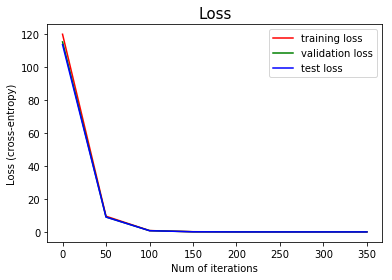

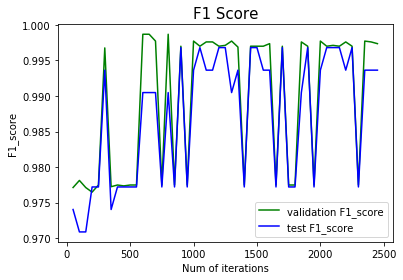

In [72]:
scale = 50

index_1 = 0
index_2 = 8
t = get_scaled_indices(index_1, index_2, scale)

plt.plot(t, l_train[index_1:index_2], 'r', label='training loss')
plt.plot(t, l_val[index_1:index_2], 'g', label='validation loss')
plt.plot(t, l_test[index_1:index_2], 'b', label='test loss')
plt.title('Loss', fontsize = 15)
plt.xlabel('Num of iterations')
plt.ylabel('Loss (cross-entropy)')
plt.legend()
plt.show()

index_1 = 1
index_2 = 50
t = get_scaled_indices(index_1, index_2, scale)

# plt.plot(t, train_F1[c:d], 'r', label='training F1_score')
plt.plot(t, valid_F1[c:d], 'g', label='validation F1_score')
plt.plot(t, test_F1[c:d], 'b', label='test F1_score')
plt.title('F1 Score', fontsize = 15)
plt.xlabel('Num of iterations')
plt.ylabel('F1_score')
plt.legend()
plt.show()

Plots for '**set_1**':
* 'cmp_bd'
* 'cmp_bm'
* 'cmp_by'

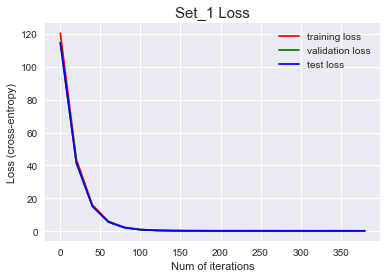

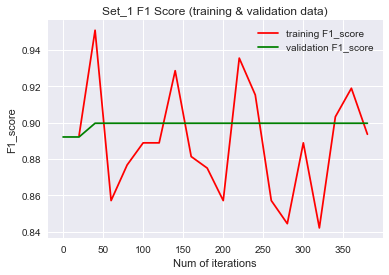

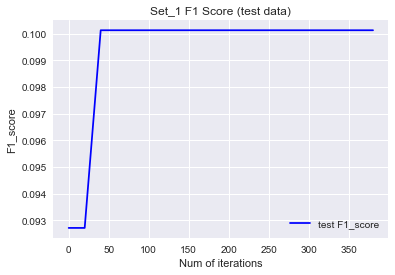

In [119]:
scale = 20

index_1 = 0
index_2 = 20
t = get_scaled_indices(index_1, index_2, scale)

plt.plot(t, l_train[index_1:index_2], 'r', label='training loss')
plt.plot(t, l_val[index_1:index_2], 'g', label='validation loss')
plt.plot(t, l_test[index_1:index_2], 'b', label='test loss')
plt.title('Set_1 Loss', fontsize = 15)
plt.xlabel('Num of iterations')
plt.ylabel('Loss (cross-entropy)')
plt.legend()
plt.show()

index_1 = 0
index_2 = 20
t = get_scaled_indices(index_1, index_2, scale)

plt.plot(t, train_F1[index_1:index_2], 'r', label='training F1_score')
plt.plot(t, valid_F1[index_1:index_2], 'g', label='validation F1_score')
plt.title('Set_1 F1 Score (training & validation data)')
plt.xlabel('Num of iterations')
plt.ylabel('F1_score')
plt.legend()
plt.show()

plt.plot(t, test_F1[index_1:index_2], 'b', label='test F1_score')
plt.title('Set_1 F1 Score (test data)')
plt.xlabel('Num of iterations')
plt.ylabel('F1_score')
plt.legend()
plt.show()

Plots for '**set_2**':
* 'cmp_fname_c1'
* 'cmp_lname_c1'
* 'cmp_sex'
* 'cmp_plz'

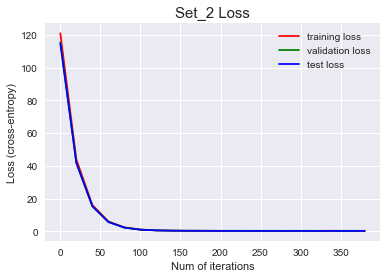

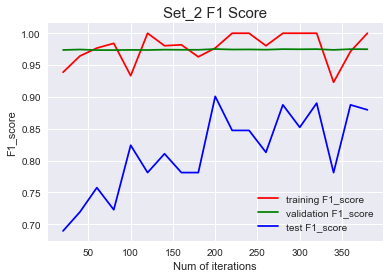

In [127]:
scale = 20

index_1 = 0
index_2 = 20
t = get_scaled_indices(index_1, index_2, scale)

plt.plot(t, l_train[index_1:index_2], 'r', label='training loss')
plt.plot(t, l_val[index_1:index_2], 'g', label='validation loss')
plt.plot(t, l_test[index_1:index_2], 'b', label='test loss')
plt.title('Set_2 Loss', fontsize = 15)
plt.xlabel('Num of iterations')
plt.ylabel('Loss (cross-entropy)')
plt.legend()
plt.show()

index_1 = 1
index_2 = 20
t = get_scaled_indices(index_1, index_2, scale)

plt.plot(t, train_F1[index_1:index_2], 'r', label='training F1_score')
plt.plot(t, valid_F1[index_1:index_2], 'g', label='validation F1_score')
plt.plot(t, test_F1[index_1:index_2], 'b', label='test F1_score')
plt.title('Set_2 F1 Score', fontsize = 15)
plt.xlabel('Num of iterations')
plt.ylabel('F1_score')
plt.legend()
plt.show()